In [2]:
import pandas as pd
import numpy as np
import sys, os
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

# Import Data and Split

In [15]:
training_data_cleaned = pd.read_pickle("./training_data.pkl")     ## Load in the cleaned data

In [20]:
test_set = training_data_cleaned.loc[training_data_cleaned["Year"] == 2016]
training_set = training_data_cleaned.loc[training_data_cleaned["Year"] < 2016]

In [104]:
test_set = test_set.drop(columns = ["ID","Flag"])

In [ ]:
def get_train_MSE(predictions, df):
    return ((df["kWh"]-predictions)**2)/len(predictions)

def get_test_MSE(predictions, df):
    return ((df["kWh"]-predictions)**2)/len(predictions)

In [26]:
predictors = training_data_cleaned.columns
predictors = list(predictors)
predictors.remove('kWh')
predictors.remove('ID')
predictors.remove('Flag')
predictors.remove('Year')
predictors.remove('Month')
predictors.remove('Day')
predictors.remove('Hour')
predictors.remove('Minute')
predictors

['RelativeHumidity',
 'DewPoint',
 'SurfaceAlbedo',
 'PrecipitableWater',
 'Pressure',
 'GHI',
 'DHI',
 'DNI',
 'WindSpeed',
 'Temperature',
 'SolarZenithAngle',
 'ClearskyGHI',
 'ClearskyDNI',
 'ClearskyDHI',
 'CloudType0',
 'CloudType1',
 'CloudType2',
 'CloudType3',
 'CloudType4',
 'CloudType8',
 'CloudType7',
 'CloudType6',
 'CloudType9',
 'CloudType10']

# Data Exploration - Dataframes

In [123]:
training_data_cleaned.head()

,ID,kWh,Flag,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,...,CloudType0,CloudType1,CloudType2,CloudType3,CloudType4,CloudType8,CloudType7,CloudType6,CloudType9,CloudType10
LocalDateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-26 00:00:00,A-1611,0.01625,M,2010.0,8.0,26.0,0.0,0.0,32.64,6.0,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 00:30:00,A-1611,0.01625,M,2010.0,8.0,26.0,0.0,30.0,34.66,6.0,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 01:00:00,A-1611,0.01600,M,2010.0,8.0,26.0,1.0,0.0,34.80,6.0,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 01:30:00,A-1611,0.01600,M,2010.0,8.0,26.0,1.0,30.0,34.80,6.0,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 02:00:00,A-1611,0.01600,M,2010.0,8.0,26.0,2.0,0.0,34.66,6.0,...,1,0,0,0,0,0,0,0,0,0


In [124]:
training_data_cleaned.corr()

,kWh,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,...,CloudType0,CloudType1,CloudType2,CloudType3,CloudType4,CloudType8,CloudType7,CloudType6,CloudType9,CloudType10
kWh,1.000000,0.050119,-0.082735,0.005791,-0.006039,-0.000264,-0.529040,-0.103879,0.184639,0.008304,...,0.345224,-0.250482,0.126743,-0.079050,-0.121710,-0.019299,-0.078948,-0.047356,-0.013181,-0.003441
Year,0.050119,1.000000,-0.133254,-0.002240,0.000713,0.000210,-0.075501,0.019953,0.080941,0.041195,...,-0.214403,0.250818,0.008996,-0.007554,-0.020302,0.146400,-0.103574,-0.000211,0.026210,-0.005623
Month,-0.082735,-0.133254,1.000000,0.003534,-0.000522,-0.000071,-0.099964,-0.037729,-0.021954,0.084044,...,0.031491,0.027046,-0.012549,-0.007037,-0.015130,-0.080146,0.002102,-0.022451,-0.003160,-0.005035
Day,0.005791,-0.002240,0.003534,1.000000,-0.000500,-0.000063,-0.021489,-0.047655,0.005795,-0.006553,...,0.008925,0.021572,0.001430,0.006146,-0.021099,-0.031980,-0.012722,0.001299,0.007704,0.003207
Hour,-0.006039,0.000713,-0.000522,-0.000500,1.000000,-0.000032,-0.227190,-0.082122,-0.000454,-0.010748,...,0.022679,-0.029193,0.023629,0.010313,-0.032525,0.004529,0.016740,-0.005874,-0.002312,0.006734
Minute,-0.000264,0.000210,-0.000071,-0.000063,-0.000032,1.000000,0.012061,-0.001295,-0.000110,-0.000156,...,-0.002334,0.003430,0.005202,-0.002191,0.002376,-0.000859,-0.003182,-0.000431,-0.000448,-0.004906
RelativeHumidity,-0.529040,-0.075501,-0.099964,-0.021489,-0.227190,0.012061,1.000000,0.401625,-0.529429,0.003464,...,-0.350428,0.117361,-0.060071,0.040218,0.193775,0.118751,0.125121,0.103702,0.027878,0.006700
DewPoint,-0.103879,0.019953,-0.037729,-0.047655,-0.082122,-0.001295,0.401625,1.000000,0.126232,0.676744,...,-0.083797,-0.051038,-0.006346,0.061078,0.008153,0.104879,0.066578,0.058095,0.021858,0.001666
SurfaceAlbedo,0.184639,0.080941,-0.021954,0.005795,-0.000454,-0.000110,-0.529429,0.126232,1.000000,0.294660,...,0.278773,-0.035219,-0.017845,-0.037078,-0.164595,-0.091791,-0.141335,-0.103573,-0.013744,0.000750
PrecipitableWater,0.008304,0.041195,0.084044,-0.006553,-0.010748,-0.000156,0.003464,0.676744,0.294660,1.000000,...,-0.051216,-0.141746,0.026559,0.066965,0.042197,0.088782,0.097190,0.082553,0.027796,0.000840


In [142]:
a = training_data_cleaned.loc[training_data_cleaned["CloudType10"] == 1]
a

,ID,kWh,Flag,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,...,CloudType0,CloudType1,CloudType2,CloudType3,CloudType4,CloudType8,CloudType7,CloudType6,CloudType9,CloudType10
LocalDateTime,,,,,,,,,,,,,,,,,,,,,
2011-03-21 22:00:00,A-1611,0.01525,M,2011.0,3.0,21.0,22.0,0.0,100.00,4.0,...,0,0,0,0,0,0,0,0,0,1
2011-04-22 20:00:00,A-1611,0.01550,M,2011.0,4.0,22.0,20.0,0.0,85.12,9.0,...,0,0,0,0,0,0,0,0,0,1


## Correlation Matrix

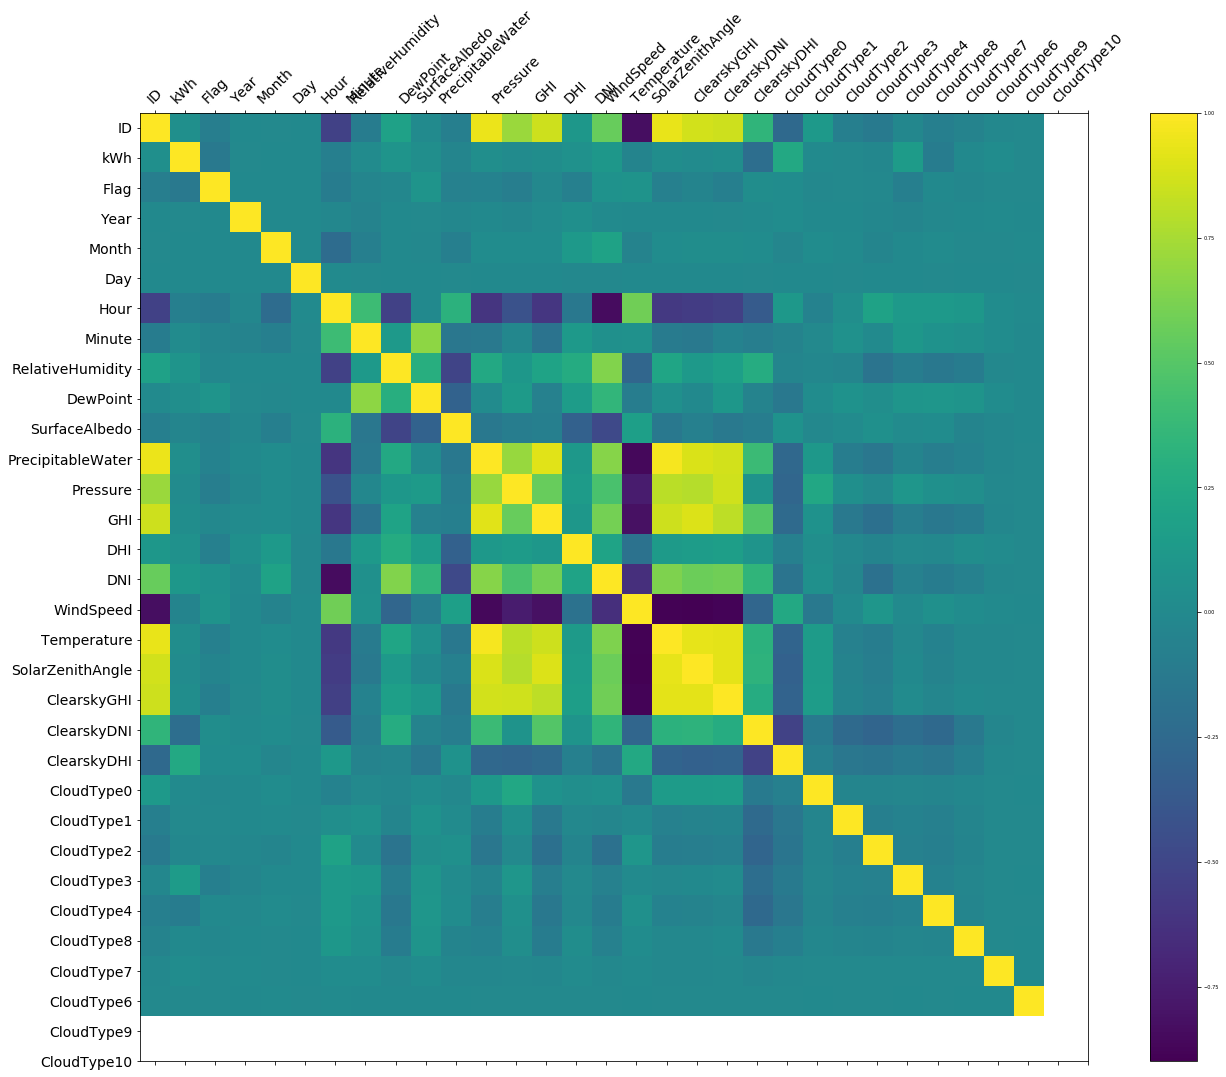

In [146]:
f = plt.figure(figsize=(22, 17))
plt.matshow(training_data_cleaned.corr(), fignum=f.number)
plt.xticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14, rotation=45)
plt.yticks(range(training_data_cleaned.shape[1]), training_data_cleaned.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=5)

Note: Cloud Type 10 has all 0 values EXCEPT for 2 rows. This is why the correlation appears white above.

# Data Exploration - Energy to Time

In [114]:
def scatter_plot(feature, target):
    plt.figure(figsize=(16, 8))
    plt.scatter(
        predicters[feature],
        predicters[target],
        c='black'
    )
    plt.xlabel("Predictor {}".format(feature))
    plt.ylabel("Solar Energy {}".format(target))
    plt.show()

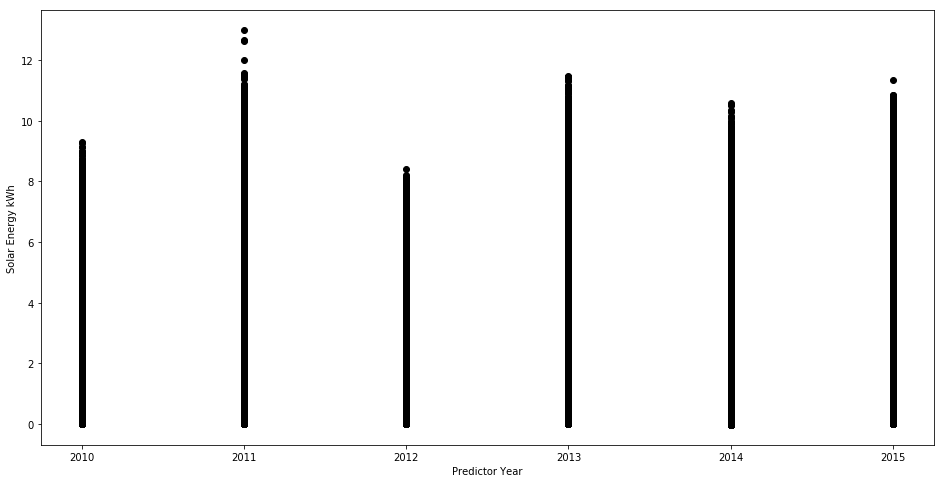

In [115]:
scatter_plot('Year','kWh')

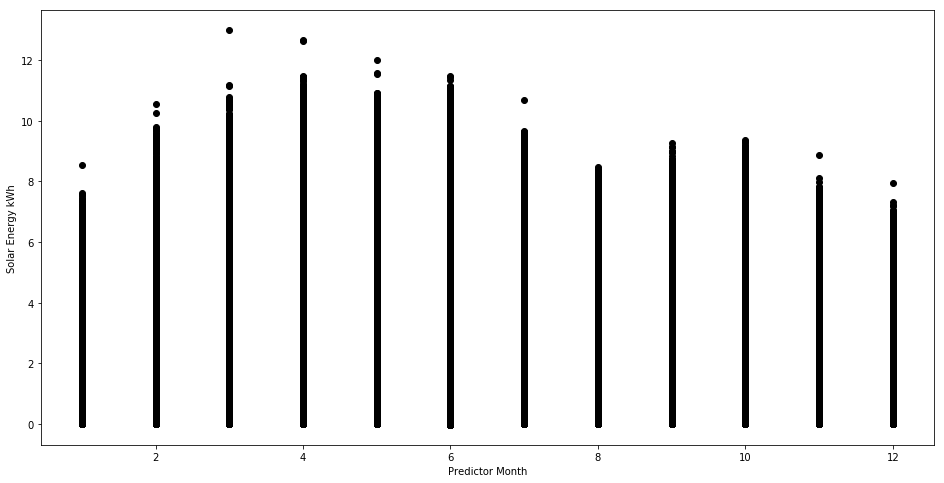

In [116]:
scatter_plot('Month','kWh')

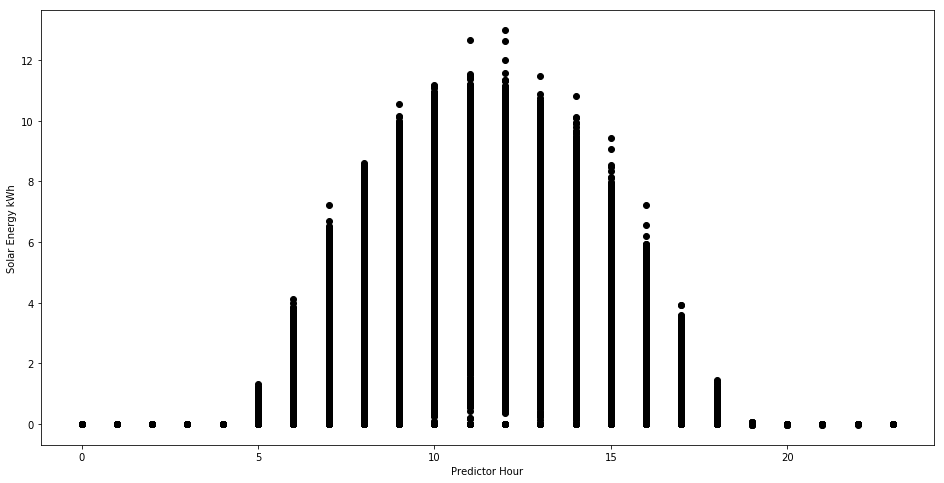

In [117]:
scatter_plot('Hour','kWh')

# Data Exploration - Energy to Weather

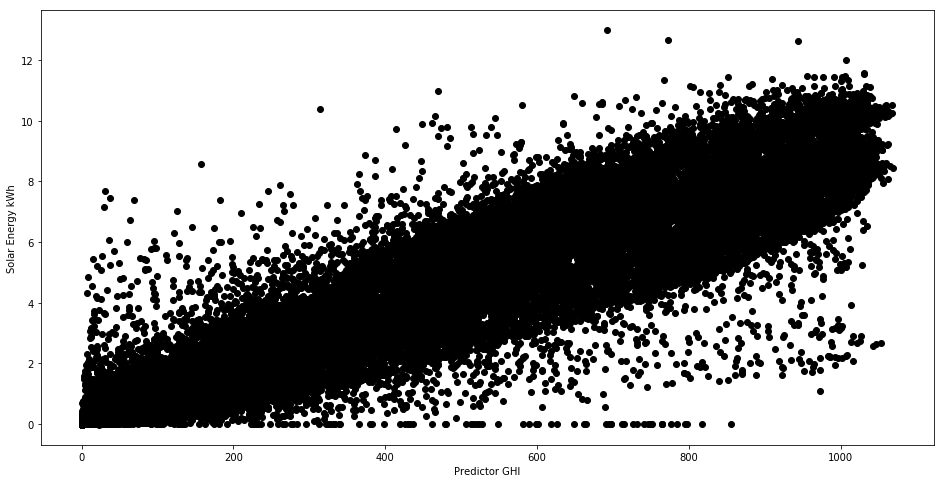

In [118]:
scatter_plot('GHI','kWh')

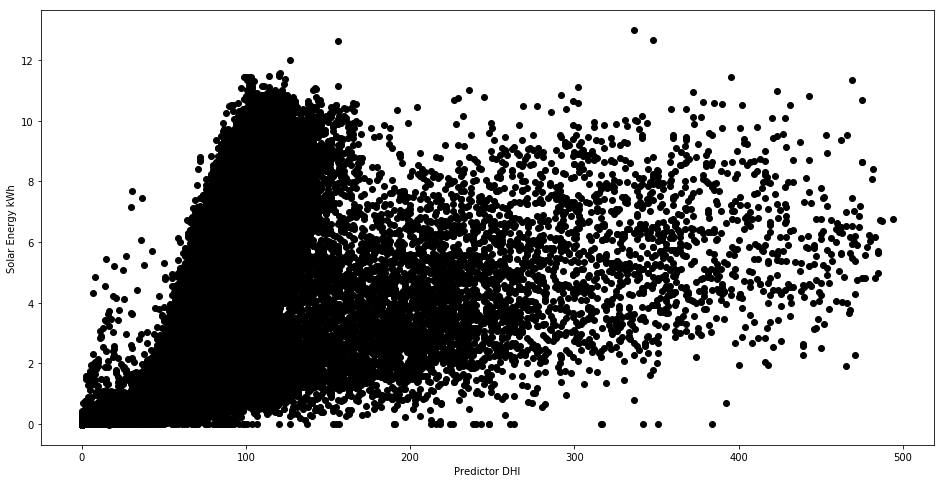

In [119]:
scatter_plot('DHI','kWh')

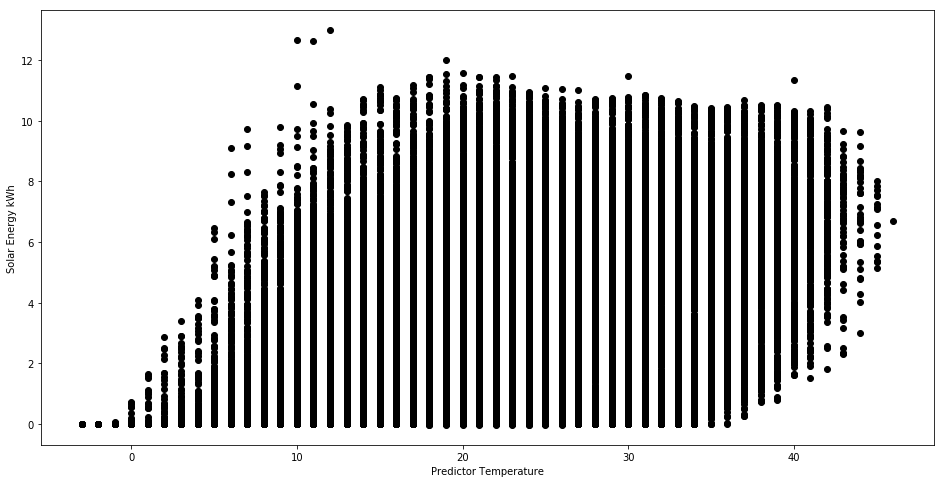

In [121]:
scatter_plot('Temperature','kWh')

# Model Selection - Forward Selection
Using k = 5 k-fold cross validation and forward selection, we find that the model with the following features:

GHI + Temperature + ClearskyGHI + DewPoint + RelativeHumidity + CloudType6 + CloudType2 + Pressure + CloudType3 + PrecipitableWater + WindSpeed + CloudType4 + CloudType0 + SolarZenithAngle + DNI + ClearskyDNI 

Although forward selection may not find the BEST combination of features, this method is heuristic and provides an efficient and practical model fit.

In [50]:
k = 5 
kf = KFold(n_splits=k, shuffle=True)

joiner = ""
used = []

for i in range(0, len(predictors),1):
    mean_training_err = []
    mean_testing_err = []
    for item in predictors:
        train_trrs = []
        test_trrs = []
        
        if item not in joiner:
            for train_index, test_index in kf.split(training_set):  #Run 5 models for 1 predictor
                df_train = training_set.iloc[train_index, :]
                df_test = training_set.iloc[test_index, :]

                formula = "kWh ~ 1 + " + joiner + item
                model = smf.ols(formula = formula, data = df_train).fit()

                train_trrs.append(get_train_MSE(model.predict(df_train))) 
                test_trrs.append(get_test_MSE(model.predict(df_test)))
               
            mean_training_err.append(np.mean(train_trrs))
            mean_testing_err.append(np.mean(test_trrs))
        
          
    choice = predictors[mean_training_err.index(min(mean_training_err))]
    joiner = joiner + choice + " + "          # String to concatenate to formula of model
    test_of_choice = mean_testing_err[mean_training_err.index(min(mean_training_err))]
    used.append([joiner, test_of_choice])     # List of the best for each value of k features
    predictors.remove(choice)
    print(joiner)
    print(test_of_choice)

In [31]:
test_mse = []
for i in range(0,len(used), 1):
    test_mse.append(used[i][1])
optimal_forward_model = used[test_mse.index(min(test_mse))]

In [60]:
best_forward = smf.ols(formula = 'kWh ~ 1 + '+ optimal_forward_model[0][0:-3], data = training_set).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    kWh   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 2.825e+04
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:51:55   Log-Likelihood:                -62019.
No. Observations:               52472   AIC:                         1.241e+05
Df Residuals:                   52448   BIC:                         1.243e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.5473      0.720     -3.540      0.000      -3.958      -1.137
GHI                   0.0080      0.000     61.515      0.000       0.008       0.008
Temperature          -0.0949      0.001    -76.373      0.000      -0.097      -0.092
ClearskyGHI           0.0017      0.000     13.682      0.000       0.001       0.002
DewPoint              0.0886      0.002     56.605      0.000       0.085       0.092
RelativeHumidity     -0.0214      0.000    -53.290      0.000      -0.022      -0.021
CloudType6           -0.4775      0.092     -5.200      0.000      -0.657      -0.297
CloudType2           -0.0324      0.093     -0.347      0.729      -0.215       0.151
Pressure              0.0051      0.001      6.661      0.000       0.004       0.007
CloudType3           -0.1985      0.091     -2.172      0.030      -0.378      -0.019
PrecipitableWater    -0.0444      0.008     -5.489      0.000      -0.060      -0.029
WindSpeed             0.0114      0.003      3.531      0.000       0.005       0.018
CloudType4           -0.2245      0.091     -2.477      0.013      -0.402      -0.047
CloudType0           -0.2458      0.091     -2.704      0.007      -0.424      -0.068
SolarZenithAngle     -0.0005      0.000     -1.947      0.052      -0.001    3.08e-06
DNI                  -0.0002   6.51e-05     -3.807      0.000      -0.000      -0.000
ClearskyDNI           0.0002    6.2e-05      3.070      0.002    6.88e-05       0.000
CloudType8           -0.2379      0.093     -2.569      0.010      -0.419      -0.056
CloudType1           -0.2765      0.091     -3.046      0.002      -0.454      -0.099
SurfaceAlbedo         0.4235      0.342      1.238      0.216      -0.247       1.094
ClearskyDHI          -0.0001      0.000     -0.513      0.608      -0.001       0.000
DHI                   0.0001      0.000      0.866      0.386      -0.000       0.000
CloudType10          -0.2154      0.513     -0.420      0.675      -1.221       0.791
CloudType9           -0.3416      0.204     -1.675      0.094      -0.741       0.058
CloudType7           -0.2972      0.091     -3.275      0.001      -0.475      -0.119
==============================================================================
Omnibus:                    18515.534   Durbin-Watson:                   0.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           352093.237
Skew:                          -1.218   Prob(JB):                         0.00
Kurtosis:                      15.454   Cond. No.                     1.90e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.15e-26. This might indicate that there are
strong multicollineari

In [105]:
predictions = best_forward.predict(test_set)
forward_test_MSE = np.mean(list(get_test_MSE(predictions, test_set)))

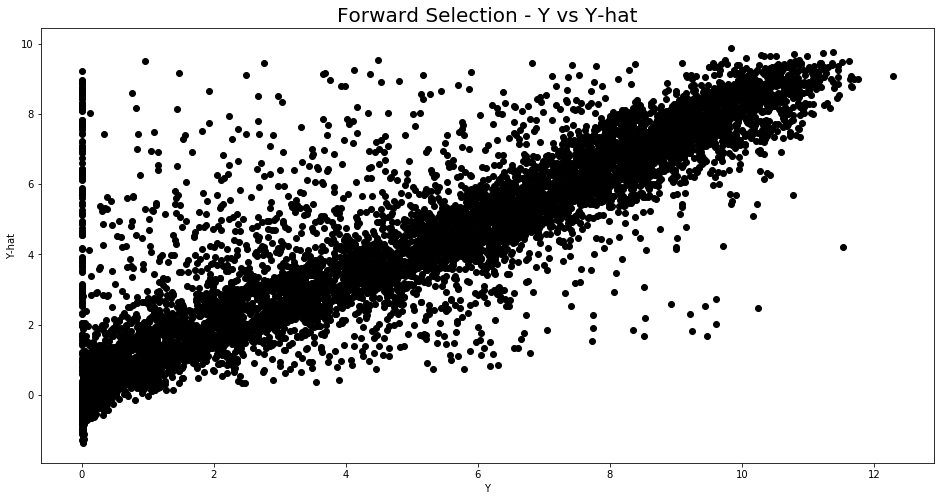

In [106]:
plt.figure(figsize=(16, 8))
plt.scatter(test_set["kWh"],predictions, c='black')
plt.xlabel("Y")
plt.ylabel("Y-hat")
plt.title("Forward Selection - Y vs Y-hat", size =20)
plt.show()

# Model Selection - Linear, Lasso, and Ridge

In [107]:
predicters = training_set.drop(columns=['ID', 'Flag'])
predicters = predicters.dropna()

In [108]:
predicters

,kWh,Year,Month,Day,Hour,Minute,RelativeHumidity,DewPoint,SurfaceAlbedo,PrecipitableWater,...,CloudType0,CloudType1,CloudType2,CloudType3,CloudType4,CloudType8,CloudType7,CloudType6,CloudType9,CloudType10
LocalDateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-26 00:00:00,0.01625,2010.0,8.0,26.0,0.0,0.0,32.64,6.0,0.191,2.963,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 00:30:00,0.01625,2010.0,8.0,26.0,0.0,30.0,34.66,6.0,0.191,2.988,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 01:00:00,0.01600,2010.0,8.0,26.0,1.0,0.0,34.80,6.0,0.191,3.014,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 01:30:00,0.01600,2010.0,8.0,26.0,1.0,30.0,34.80,6.0,0.191,3.035,...,1,0,0,0,0,0,0,0,0,0
2010-08-26 02:00:00,0.01600,2010.0,8.0,26.0,2.0,0.0,34.66,6.0,0.191,3.056,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 21:30:00,0.01475,2015.0,12.0,31.0,21.0,30.0,74.47,-3.0,0.156,0.456,...,0,0,0,0,1,0,0,0,0,0
2015-12-31 22:00:00,0.01500,2015.0,12.0,31.0,22.0,0.0,73.54,-4.0,0.156,0.459,...,0,0,0,0,1,0,0,0,0,0
2015-12-31 22:30:00,0.01500,2015.0,12.0,31.0,22.0,30.0,73.54,-4.0,0.156,0.463,...,0,1,0,0,0,0,0,0,0,0


In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

Xs = predicters.drop(['kWh'], axis=1)
y = predicters['kWh'].values.reshape(-1,1)

lin_reg = LinearRegression()

MSEs = cross_val_score(lin_reg, Xs, y, scoring='neg_mean_squared_error', cv=5)

mean_MSE = np.mean(MSEs)

print(mean_MSE)

-0.7096834864542118


In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 40, 80, 160, 320, 640, 1280]

ridge = Ridge()

parameters = {'alpha': alpha}

ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)

ridge_regressor.fit(Xs, y)

C:\Users\Stephen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.247502e-26
  overwrite_a=True).T
C:\Users\Stephen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.094931e-22
  overwrite_a=True).T
C:\Users\Stephen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.881887e-23
  overwrite_a=True).T
C:\Users\Stephen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 40, 80, 160, 320, 640, 1280]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
ridge_regressor.best_params_

{'alpha': 1280}

In [112]:
ridge_regressor.best_score_


-0.704794289274597

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso()

parameters = {'alpha': alpha}

lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv = 5)

lasso_regressor.fit(Xs, y)

In [97]:
lasso_regressor.best_params_

{'alpha': 0.01}

In [98]:
lasso_regressor.best_score_

-0.6981099275256923